In [2]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

In [3]:
df = pd.read_csv('../data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})
df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

df = df.drop(columns=["lat","lng","direccion","id","fecha","descripcion","titulo"])

In [4]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.score(test_features,test_labels)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(predict*100))
    
    return predict

In [5]:
def imputar(df,cols):
    imp = SimpleImputer()
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [6]:
#Columnas numericas

data_cols = df._get_numeric_data().columns

#Completo los nulos
df1 = imputar(df,data_cols)

baseline_data = df1[data_cols]

#Normalizo
min_max_scaler = MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(baseline_data)

baseline_data = pd.DataFrame(x_scaled,columns=data_cols)

In [15]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['ciudad', 'provincia', 'tipodepropiedad']

encoder = ce.BinaryEncoder()

encoded = encoder.fit_transform(df1[cat_features])

data = baseline_data.join(encoded)

data.dropna(inplace=True)

x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [16]:
lgb_model = lgb.LGBMRegressor(n_estimators=300)
lgb_model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [17]:
predecir(lgb_model,x_train,y_train,x_test,y_test)

Entrenamiento: 80.8701%
Testeo: 78.5020%.


0.7850202296040247

<BarContainer object of 38 artists>

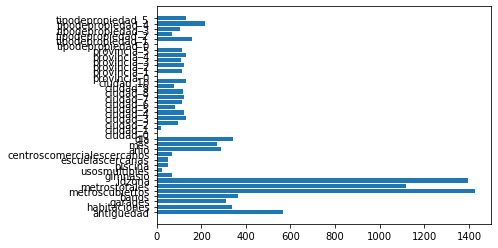

In [14]:
importancia = lgb_model.feature_importances_
plt.barh(x.columns, lgb_model.feature_importances_)